In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 10
BATCH = 64
LR = 0.001

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_train_norm = ds_train.map(normalize_img).cache().shuffle(1000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
ds_test_norm  = ds_test.map(normalize_img).batch(BATCH).prefetch(tf.data.AUTOTUNE)


In [3]:
def evaluate_model(model, dataset, name="model"):
    loss, acc = model.evaluate(dataset, verbose=0)
    print(f"{name}: loss={loss:.4f}, accuracy={acc:.4f}")
    return loss, acc


In [4]:
def build_baseline_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline = build_baseline_model()
baseline.fit(ds_train_norm, epochs=EPOCHS, validation_data=ds_test_norm)

evaluate_model(baseline, ds_test_norm, "baseline (test)")


Epoch 1/10


/Users/xyz/Main/IML/iml_lab_2025/s30890/08/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 93/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6229 - loss: 1.2925

2025-11-27 23:10:55.531929: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9153 - loss: 0.3025 - val_accuracy: 0.9425 - val_loss: 0.1932
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9600 - loss: 0.1377 - val_accuracy: 0.9666 - val_loss: 0.1135
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9723 - loss: 0.0943 - val_accuracy: 0.9684 - val_loss: 0.1017
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9785 - loss: 0.0721 - val_accuracy: 0.9737 - val_loss: 0.0891
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9830 - loss: 0.0570 - val_accuracy: 0.9729 - val_loss: 0.0878
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9867 - loss: 0.0466 - val_accuracy: 0.9755 - val_loss: 0.0786
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9889 - loss: 0.0377 - val_accuracy: 0.9766 - val_loss: 0.0770
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9917 - loss: 0.0303 - val_accuracy: 0.9777 - val_

(0.08101446181535721, 0.9768000245094299)

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])


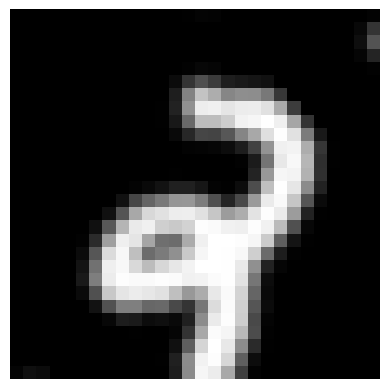

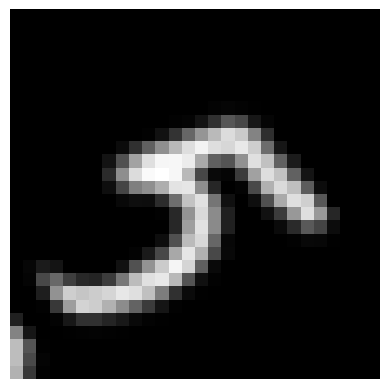

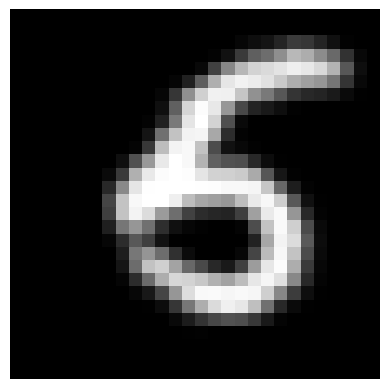

2025-11-27 23:11:24.422348: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
for images, labels in ds_train_norm.take(1):
    for i in range(3):
        aug_img = data_augmentation(images)[i]
        plt.imshow(aug_img.numpy().squeeze(), cmap='gray')
        plt.axis("off")
        plt.show()


In [7]:
def augment_for_test(image, label):
    # negatyw (30%)
    if tf.random.uniform(()) < 0.3:
        image = 1.0 - image

    # losowy obrót 0/90/180/270
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    # losowe przesunięcie (pad + crop)
    dx = tf.random.uniform((), -3, 3, dtype=tf.int32)
    dy = tf.random.uniform((), -3, 3, dtype=tf.int32)

    # powiększamy do 34x34
    image = tf.image.pad_to_bounding_box(image, 3, 3, 34, 34)

    # przywracamy 28x28 z przesunięciem
    image = tf.image.crop_to_bounding_box(image, 3 + dy, 3 + dx, 28, 28)

    return image, label

ds_test_aug = ds_test.map(normalize_img).map(augment_for_test).batch(BATCH)
evaluate_model(baseline, ds_test_aug, "baseline (augmented test)")


baseline (augmented test): loss=18.5535, accuracy=0.2351


(18.553516387939453, 0.23510000109672546)

In [8]:
def build_baseline_model_aug():
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1.0, input_shape=(28, 28, 1)), # dane już są 0–1
        data_augmentation,   # augmentacja tylko w treningu
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline_aug = build_baseline_model_aug()
baseline_aug.fit(ds_train_norm, epochs=EPOCHS)


Epoch 1/10


/Users/xyz/Main/IML/iml_lab_2025/s30890/08/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7132 - loss: 0.9263
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8543 - loss: 0.4869
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8794 - loss: 0.4007
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8899 - loss: 0.3664
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8983 - loss: 0.3379
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9035 - loss: 0.3226
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9081 - loss: 0.3024
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9125 - loss: 0.2901
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9135 - loss: 0.2819
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9170 - loss: 0.2745


In [9]:
evaluate_model(baseline_aug, ds_test_norm, "baseline_aug (test)")
evaluate_model(baseline_aug, ds_test_aug, "baseline_aug (aug test)")


baseline_aug (test): loss=0.1508, accuracy=0.9542
baseline_aug (aug test): loss=10.2699, accuracy=0.3748


(10.269867897033691, 0.3747999966144562)

In [10]:
def build_conv_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1.0, input_shape=(28, 28, 1)),
        data_augmentation,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

conv_model = build_conv_model()
conv_model.fit(ds_train_norm, epochs=EPOCHS, validation_data=ds_test_norm)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8324 - loss: 0.5224 - val_accuracy: 0.9582 - val_loss: 0.1299
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9390 - loss: 0.1995 - val_accuracy: 0.9638 - val_loss: 0.1151
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9553 - loss: 0.1459 - val_accuracy: 0.9753 - val_loss: 0.0815
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9615 - loss: 0.1218 - val_accuracy: 0.9816 - val_loss: 0.0592
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9668 - loss: 0.1075 - val_accuracy: 0.9756 - val_loss: 0.0711
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9706 - loss: 0.0965 - val_accuracy: 0.9805 - val_loss: 0.0669
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9737 - loss: 0.0855 - val_accuracy: 0.9822 - val_loss: 0.0573
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9752 - loss: 0.0818 - val_accuracy: 0.

In [11]:
evaluate_model(conv_model, ds_test_norm, "CNN (test)")
evaluate_model(conv_model, ds_test_aug, "CNN (aug test)")


CNN (test): loss=0.0470, accuracy=0.9852
CNN (aug test): loss=4.6350, accuracy=0.4641


(4.634981632232666, 0.4641000032424927)